<a href="https://colab.research.google.com/github/mojtabaSefidi/Machine-Learning-with-Graphs/blob/main/MLG_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Essential Packages

In [1]:
!pip install -q torch_geometric
!pip install -q torch-sparse==0.6.13
!pip install -q torch_scatter

## Install Essential Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, SAGEConv

from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [2]:
def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):
    
    plt.figure(figsize=(18,8),linewidth = 7, edgecolor="whitesmoke")    
    n = n_epochs
    
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss,'b',marker=".")
    
    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')  
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')
    
    plt.legend(['Train Accuracy','Train Loss','Test Accuracy','Test Loss'])
    plt.grid(True)
    
    # plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

## Read the Dataset

In [3]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=NormalizeFeatures())

## Split the Dataset

In [4]:
def split_data(dataset, train_split_percentage):
  cut_index = int(len(dataset) * train_split_percentage)
  dataset = dataset.shuffle()
  return dataset[:cut_index], dataset[cut_index:]

In [5]:
train_dataset, test_dataset = split_data(dataset, train_split_percentage=0.8)
print(f'Number of graphs in the Train Dataset: {len(train_dataset)}')
print(f'Number of graphs in the Test Dataset: {len(test_dataset)}')

Number of graphs in the Train Dataset: 150
Number of graphs in the Test Dataset: 38


## Batch Generator

In [6]:
def batch_generator(train_dataset, test_dataset, batch_size, shuffle=True):
  train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
  test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
  return train_data_loader, test_data_loader

In [7]:
train_data_loader, test_data_loader =  batch_generator(train_dataset, test_dataset, batch_size=64)

for batch, data in enumerate(train_data_loader):
    print(f'Batch {batch + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()


Batch 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2498], x=[1134, 7], edge_attr=[2498, 4], y=[64], batch=[1134], ptr=[65])

Batch 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2544], x=[1155, 7], edge_attr=[2544, 4], y=[64], batch=[1155], ptr=[65])

Batch 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 812], x=[370, 7], edge_attr=[812, 4], y=[22], batch=[370], ptr=[23])



In [41]:
class GCN_Add_Pooling(torch.nn.Module):
    
    def __init__(self, hidden_channels, aggregation):
        super(GCN_Add_Pooling, self).__init__()
        torch.manual_seed(12345)
        if type(aggregation) != list:
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels, aggr=aggregation)
          self.conv2 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv3 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.conv4 = GCNConv(hidden_channels, hidden_channels, aggr=aggregation)
          self.lin = Linear(hidden_channels, dataset.num_classes)
        else:
          i=1
          self.conv1 = GCNConv(dataset.num_node_features, hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv2 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv3 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          i+=1
          self.conv4 = GCNConv(hidden_channels*(len(aggregation)**(i)), hidden_channels*(len(aggregation)**(i)), aggr=aggregation, bias=False)
          self.lin = Linear(hidden_channels*(len(aggregation)**(i+1)), dataset.num_classes)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


In [42]:
class Graph_Sage(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Sage, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [43]:
class Graph_Conv(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Graph_Conv, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        x = global_add_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [44]:
class Leaning_Evaluation(torch.nn.Module):
    def __init__(
        self,
        model,
        learning_rate=0.006,
        best_results=[0, 0, 0],
        ):
      
      super().__init__()
      self.model = model
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
      self.criterion = torch.nn.CrossEntropyLoss()
      self.best_results = best_results
    
    def train(self, data_loader):
        self.model.train()

        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss = self.criterion(out, data.y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

    def evaluate(self, data_loader):
        self.model.eval()

        correct, loss = 0, 0
        for data in data_loader:
            out = self.model(data.x, data.edge_index, data.batch)
            loss += self.criterion(out, data.y)  
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
        return correct / len(data_loader.dataset), loss/ len(data_loader.dataset)

    def train_and_evaluate(self, train_data_loader, test_data_loader, n_epochs=200):
      
      list_train_acc, list_train_loss, list_test_acc, list_test_loss = [], [], [], []
      print('Train and Evaluation started...')
      for epoch in range(1, n_epochs+1):
          self.train(train_data_loader)
          
          train_accuracy, train_loss = self.evaluate(train_data_loader)
          list_train_acc.append(train_accuracy)
          list_train_loss.append(float(train_loss.detach()))
          
          test_accuracy, test_loss = self.evaluate(test_data_loader)
          if self.best_results[-1] + self.best_results[1] < test_accuracy + train_accuracy :
            self.best_results[0], self.best_results[1], self.best_results[-1] = epoch, train_accuracy ,test_accuracy

          list_test_acc.append(test_accuracy)
          list_test_loss.append(float(test_loss.detach()))

          print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')
      
      print('---------------------------------------------------')
      print('Train and Evaluation finished...')
      print(f'Best Results of the model : Epoch: {self.best_results[0]:03d}, Train Accuracy: {self.best_results[1]:.4f}, Test Accuracy: {self.best_results[-1]:.4f}')
      return list_train_acc, list_train_loss, list_test_acc, list_test_loss
      

### Aggregation Function = add

In [45]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='add')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [46]:
evaluate_GCN_add = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_add.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6533, Train Loss: 0.0122, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 002, Train Accuracy: 0.6533, Train Loss: 0.0122, Test Accuracy: 0.7105, Test Loss: 0.0157
Epoch: 003, Train Accuracy: 0.6533, Train Loss: 0.0113, Test Accuracy: 0.7105, Test Loss: 0.0142
Epoch: 004, Train Accuracy: 0.6533, Train Loss: 0.0115, Test Accuracy: 0.7105, Test Loss: 0.0145
Epoch: 005, Train Accuracy: 0.6533, Train Loss: 0.0114, Test Accuracy: 0.7105, Test Loss: 0.0142
Epoch: 006, Train Accuracy: 0.6533, Train Loss: 0.0108, Test Accuracy: 0.7105, Test Loss: 0.0139
Epoch: 007, Train Accuracy: 0.6533, Train Loss: 0.0108, Test Accuracy: 0.7105, Test Loss: 0.0137
Epoch: 008, Train Accuracy: 0.6533, Train Loss: 0.0106, Test Accuracy: 0.7105, Test Loss: 0.0136
Epoch: 009, Train Accuracy: 0.6533, Train Loss: 0.0113, Test Accuracy: 0.7105, Test Loss: 0.0134
Epoch: 010, Train Accuracy: 0.6533, Train Loss: 0.0111, Test Accuracy: 0.7105, Test Loss: 0.013

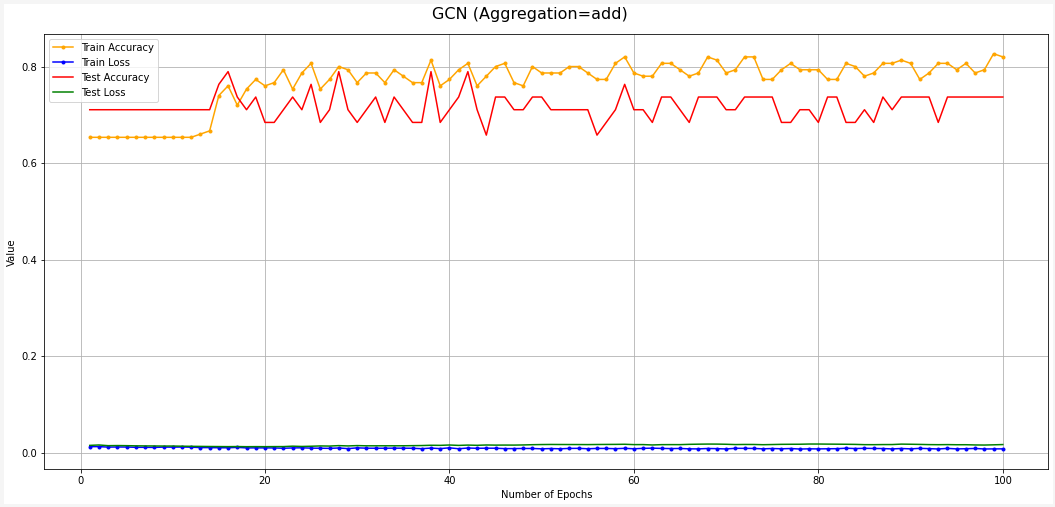

In [47]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=add)')

### Aggregation Function = Max

In [48]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='max')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [49]:
evaluate_GCN_max = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_max.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6533, Train Loss: 0.0120, Test Accuracy: 0.7105, Test Loss: 0.0152
Epoch: 002, Train Accuracy: 0.6533, Train Loss: 0.0117, Test Accuracy: 0.7105, Test Loss: 0.0151
Epoch: 003, Train Accuracy: 0.6533, Train Loss: 0.0118, Test Accuracy: 0.7105, Test Loss: 0.0152
Epoch: 004, Train Accuracy: 0.6533, Train Loss: 0.0118, Test Accuracy: 0.7105, Test Loss: 0.0149
Epoch: 005, Train Accuracy: 0.6533, Train Loss: 0.0116, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 006, Train Accuracy: 0.6533, Train Loss: 0.0113, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 007, Train Accuracy: 0.6533, Train Loss: 0.0113, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 008, Train Accuracy: 0.6533, Train Loss: 0.0112, Test Accuracy: 0.7105, Test Loss: 0.0146
Epoch: 009, Train Accuracy: 0.6533, Train Loss: 0.0118, Test Accuracy: 0.7105, Test Loss: 0.0145
Epoch: 010, Train Accuracy: 0.6533, Train Loss: 0.0117, Test Accuracy: 0.7105, Test Loss: 0.014

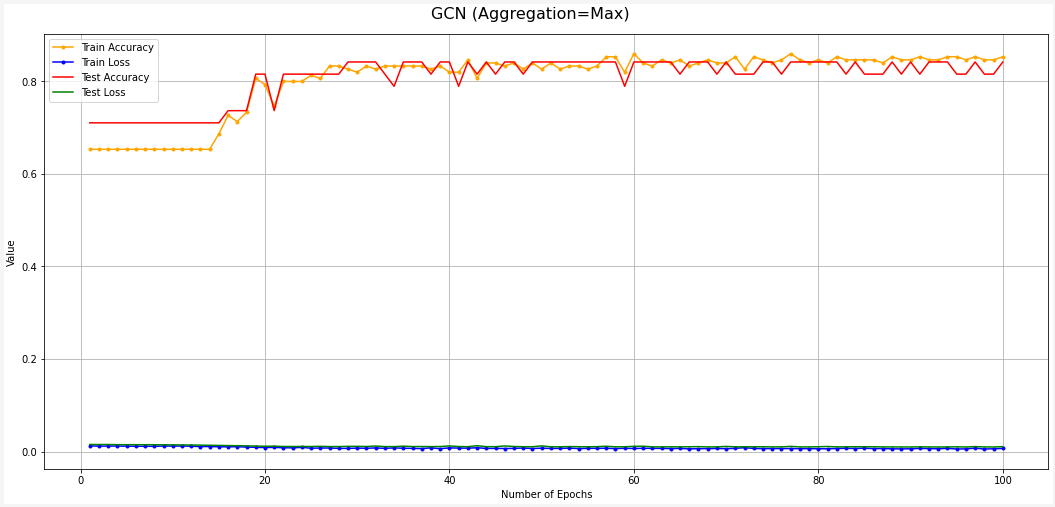

In [50]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=Max)')

### Aggregation Function = Min

In [51]:
model = GCN_Add_Pooling(hidden_channels=64, aggregation='mean')
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [52]:
evaluate_GCN_mean = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_mean.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6533, Train Loss: 0.0121, Test Accuracy: 0.7105, Test Loss: 0.0153
Epoch: 002, Train Accuracy: 0.6533, Train Loss: 0.0116, Test Accuracy: 0.7105, Test Loss: 0.0150
Epoch: 003, Train Accuracy: 0.6533, Train Loss: 0.0118, Test Accuracy: 0.7105, Test Loss: 0.0151
Epoch: 004, Train Accuracy: 0.6533, Train Loss: 0.0119, Test Accuracy: 0.7105, Test Loss: 0.0149
Epoch: 005, Train Accuracy: 0.6533, Train Loss: 0.0117, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 006, Train Accuracy: 0.6533, Train Loss: 0.0114, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 007, Train Accuracy: 0.6533, Train Loss: 0.0114, Test Accuracy: 0.7105, Test Loss: 0.0149
Epoch: 008, Train Accuracy: 0.6533, Train Loss: 0.0114, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 009, Train Accuracy: 0.6533, Train Loss: 0.0120, Test Accuracy: 0.7105, Test Loss: 0.0148
Epoch: 010, Train Accuracy: 0.6533, Train Loss: 0.0120, Test Accuracy: 0.7105, Test Loss: 0.014

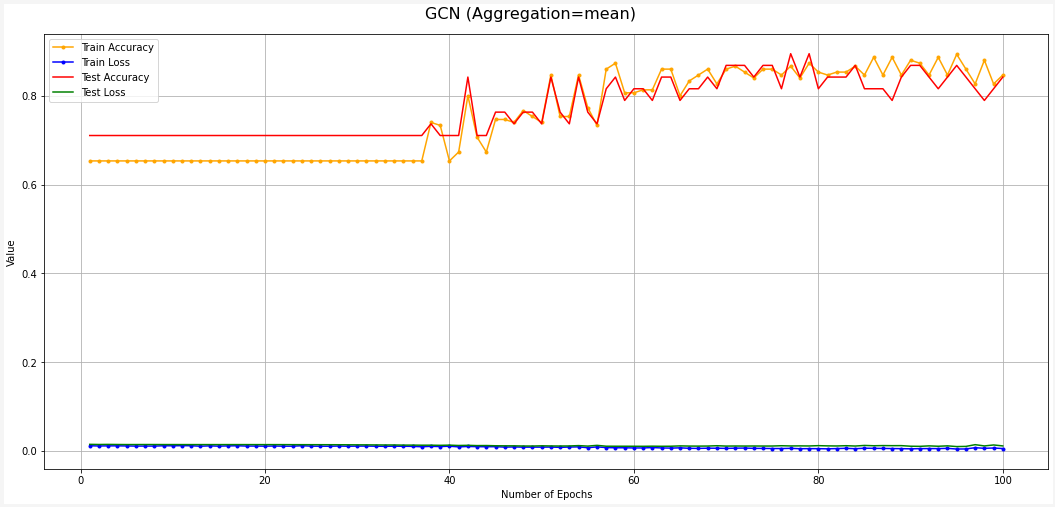

In [53]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=mean)')

### Aggregation Function = [Add, Max, Min]

In [54]:
model = GCN_Add_Pooling(hidden_channels=8, aggregation=['add','mean','max'])
print(model)

GCN_Add_Pooling(
  (conv1): GCNConv(7, 24)
  (conv2): GCNConv(72, 72)
  (conv3): GCNConv(216, 216)
  (conv4): GCNConv(648, 648)
  (lin): Linear(in_features=1944, out_features=2, bias=True)
)


In [55]:
evaluate_GCN_all = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GCN_all.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=100)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6533, Train Loss: 0.0111, Test Accuracy: 0.7105, Test Loss: 0.0144
Epoch: 002, Train Accuracy: 0.7067, Train Loss: 0.0127, Test Accuracy: 0.7368, Test Loss: 0.0163
Epoch: 003, Train Accuracy: 0.6533, Train Loss: 0.0116, Test Accuracy: 0.7105, Test Loss: 0.0146
Epoch: 004, Train Accuracy: 0.6600, Train Loss: 0.0107, Test Accuracy: 0.7105, Test Loss: 0.0134
Epoch: 005, Train Accuracy: 0.7333, Train Loss: 0.0096, Test Accuracy: 0.7368, Test Loss: 0.0127
Epoch: 006, Train Accuracy: 0.7800, Train Loss: 0.0093, Test Accuracy: 0.7368, Test Loss: 0.0122
Epoch: 007, Train Accuracy: 0.7733, Train Loss: 0.0085, Test Accuracy: 0.7368, Test Loss: 0.0133
Epoch: 008, Train Accuracy: 0.7600, Train Loss: 0.0101, Test Accuracy: 0.7632, Test Loss: 0.0165
Epoch: 009, Train Accuracy: 0.7733, Train Loss: 0.0082, Test Accuracy: 0.7368, Test Loss: 0.0158
Epoch: 010, Train Accuracy: 0.7733, Train Loss: 0.0081, Test Accuracy: 0.7105, Test Loss: 0.014

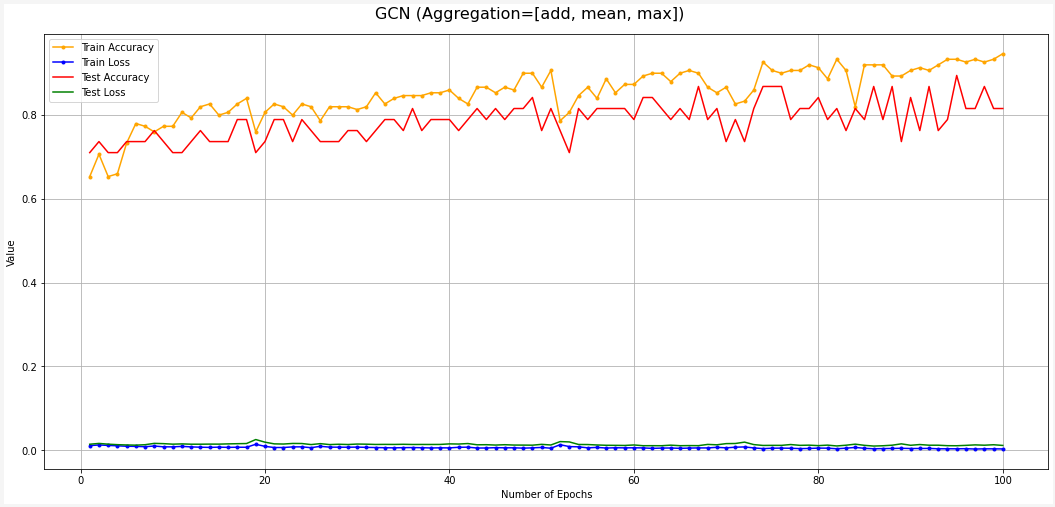

In [56]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=100, title='GCN (Aggregation=[add, mean, max])')

### GraphSage

In [57]:
model = Graph_Sage(hidden_channels=64)
print(model)

Graph_Sage(
  (conv1): SAGEConv(7, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [58]:
evaluate_GraphSage = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphSage.train_and_evaluate(train_data_loader, test_data_loader, n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6533, Train Loss: 0.0181, Test Accuracy: 0.7105, Test Loss: 0.0231
Epoch: 002, Train Accuracy: 0.6800, Train Loss: 0.0129, Test Accuracy: 0.8158, Test Loss: 0.0162
Epoch: 003, Train Accuracy: 0.6600, Train Loss: 0.0107, Test Accuracy: 0.7105, Test Loss: 0.0131
Epoch: 004, Train Accuracy: 0.6533, Train Loss: 0.0128, Test Accuracy: 0.7105, Test Loss: 0.0158
Epoch: 005, Train Accuracy: 0.6600, Train Loss: 0.0108, Test Accuracy: 0.7105, Test Loss: 0.0132
Epoch: 006, Train Accuracy: 0.7200, Train Loss: 0.0117, Test Accuracy: 0.7895, Test Loss: 0.0147
Epoch: 007, Train Accuracy: 0.6800, Train Loss: 0.0099, Test Accuracy: 0.7105, Test Loss: 0.0129
Epoch: 008, Train Accuracy: 0.6533, Train Loss: 0.0103, Test Accuracy: 0.7105, Test Loss: 0.0142
Epoch: 009, Train Accuracy: 0.6733, Train Loss: 0.0105, Test Accuracy: 0.7105, Test Loss: 0.0130
Epoch: 010, Train Accuracy: 0.7867, Train Loss: 0.0107, Test Accuracy: 0.7368, Test Loss: 0.013

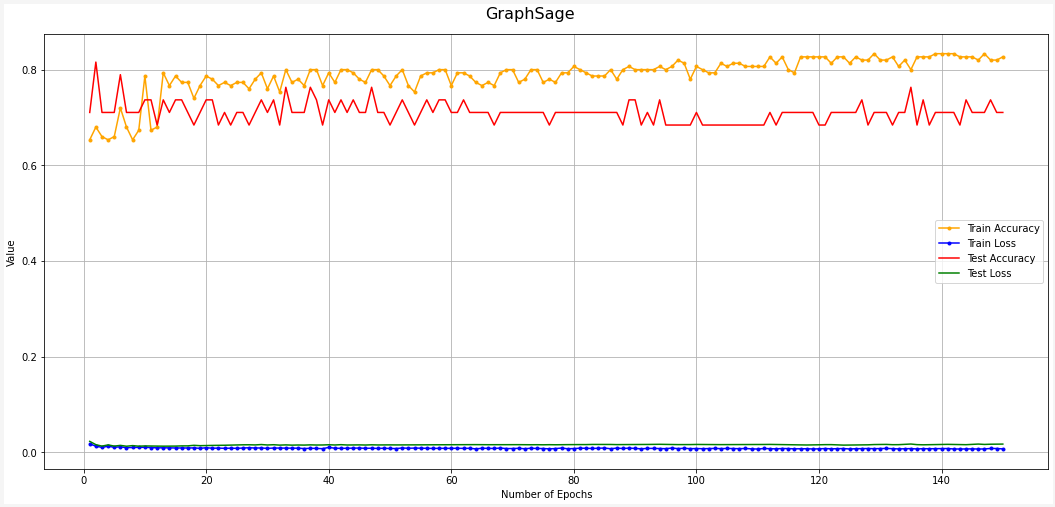

In [59]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphSage')

### GraphConv

In [60]:
model = Graph_Conv(hidden_channels=64)
print(model)

Graph_Conv(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [61]:
evaluate_GraphConv = Leaning_Evaluation(
                                   model = model,
                                   learning_rate=0.002,
                                   best_results=[0, 0, 0]
                                   )
list_train_acc, list_train_loss, list_test_acc, list_test_loss = evaluate_GraphConv.train_and_evaluate(train_data_loader, test_data_loader,  n_epochs=150)

Train and Evaluation started...
Epoch: 001, Train Accuracy: 0.6533, Train Loss: 0.0122, Test Accuracy: 0.7105, Test Loss: 0.0155
Epoch: 002, Train Accuracy: 0.6533, Train Loss: 0.0162, Test Accuracy: 0.7105, Test Loss: 0.0203
Epoch: 003, Train Accuracy: 0.6533, Train Loss: 0.0126, Test Accuracy: 0.7105, Test Loss: 0.0171
Epoch: 004, Train Accuracy: 0.7733, Train Loss: 0.0091, Test Accuracy: 0.8421, Test Loss: 0.0103
Epoch: 005, Train Accuracy: 0.6600, Train Loss: 0.0099, Test Accuracy: 0.7105, Test Loss: 0.0122
Epoch: 006, Train Accuracy: 0.7467, Train Loss: 0.0086, Test Accuracy: 0.7632, Test Loss: 0.0107
Epoch: 007, Train Accuracy: 0.7933, Train Loss: 0.0082, Test Accuracy: 0.7895, Test Loss: 0.0107
Epoch: 008, Train Accuracy: 0.6733, Train Loss: 0.0085, Test Accuracy: 0.6842, Test Loss: 0.0117
Epoch: 009, Train Accuracy: 0.7933, Train Loss: 0.0088, Test Accuracy: 0.7895, Test Loss: 0.0107
Epoch: 010, Train Accuracy: 0.8000, Train Loss: 0.0086, Test Accuracy: 0.7895, Test Loss: 0.010

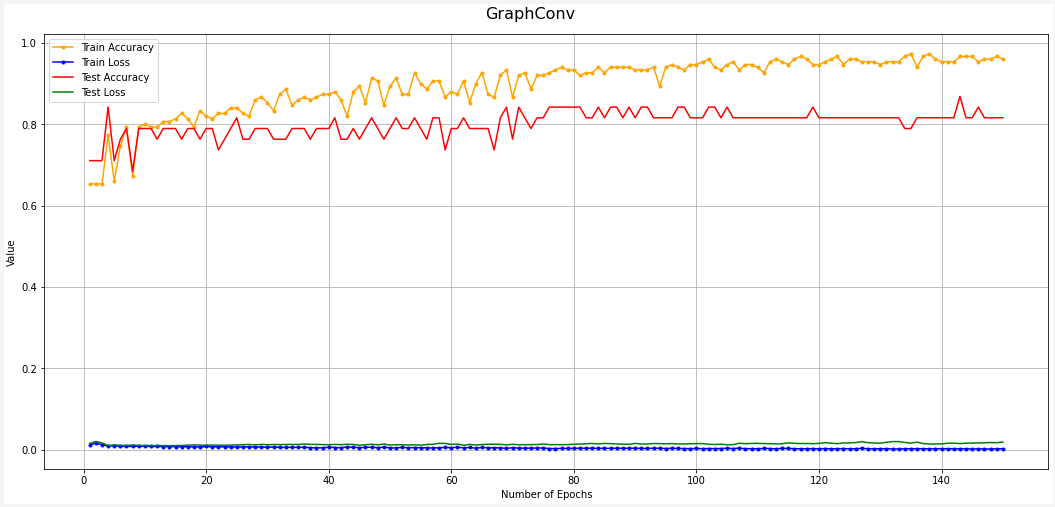

In [62]:
plot_history(list_train_loss, list_train_acc, list_test_loss, list_test_acc, n_epochs=150, title='GraphConv')

In [ ]:
import pandas as pd

conclusion = pd.DataFrame([['GCN (Mean polling)' ,0.8933, 0.7368, 165],
              ['GCN (Max polling)',0.8933, 0.7368, 165],
              ['GCN (Add polling)',0.8867, 0.7895, 165],
              ['GraphSage (Add polling)',0.8667, 0.8421, 182],
              ['GraphConv (Add polling)',0.9533, 0.8947, 192]],
              columns=["Model Details","Train Accuracy", "Train loss", "Test Accuracy", "Test loss", 'Epoch with best result'])
conclusion = conclusion.set_index('Model Details')
conclusion.style.background_gradient(cmap="YlOrRd")

